**Objectives**

Provide an overview of some machine learning models, using the latest iteration of the input data.

**Applied Data Filters**

The dataframe included in this analysis contains the following modifications of the original data set:

1. Meal level aggregation
2. Meals that are only lunch or dinner
3. Meals that have both seafood and meat, where there is ambiguity in the ratio, are dropped
4. Meals that are more than 0 KCAL
5. Meals of participants older than 18 years of age
6. Meals that are consumed at home
7. Meals that are non-vegeterian 

**Section 1: Logistic Regression Model**

**Model Evaluation**

This section evaluated the performance of the logistic regression model over several model fittings. This is done to account for the random sampling of the model data. The performance is measured by a split of the data into training and test sets, using an 80% training and 20% test split. The prediction success rate of the model is used as the evaluation criteria. 

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def nhanes_full_log_reg(df, fped_vars, non_sfd_class_n, sfd_class_n, test_ratio):
    
    #Sample the seafood and non-seafood classes, create model input df
    df_non_sfd = df[df['seafood_meal']==0].sample(n=non_sfd_class_n)
    df_sfd = df[df['seafood_meal']==1].sample(n=sfd_class_n)
    df_mdl = pd.concat([df_non_sfd, df_sfd])
    #Add the classification target variable to the df input list
    fped_vars.append('seafood_meal')
    #Use variable combination selected by loop
    df_mdl = df_mdl[fped_vars]
    #Split the training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_mdl.drop(['seafood_meal'], axis=1), df_mdl['seafood_meal'], test_size=test_ratio)
    #Fit the logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    #Obtain predictions on test set and calculate success rate
    y_pred = log_reg.predict(X_test)
    y_pred_train = log_reg.predict(X_train)
    n_correct = sum(y_pred == y_test)
    pred_sr = [str(n_correct/len(y_pred))]
    n_correct_train = sum(y_pred_train == y_train)
    pred_sr_train = [str(n_correct_train/len(y_pred_train))]
    #Calculate model execution time for combinatorial variable selection    
    #non_cmb_time = time.time() - startTime  
    #non_cmb_time_df = pd.DataFrame([non_cmb_time ])
    #non_cmb_time_df = non_cmb_time_df.rename({0: 'Runtime(Seconds)'}, axis=1)
    #Create a dataframe with variables used and their success rate    
    pred_sr_df = pd.DataFrame(pred_sr)
    pred_sr_df = pred_sr_df.rename({0: 'Success Rate'}, axis=1)
    pred_sr_train_df = pd.DataFrame(pred_sr_train)
    pred_sr_train_df = pred_sr_train_df.rename({0: 'Success Rate Train'}, axis=1)
    fped_vars.remove('seafood_meal')
    var_list_df = pd.DataFrame([fped_vars])
    #model_result = pd.concat([var_list_df, pred_sr_df, non_cmb_time_df], axis=1)
    model_result = pd.concat([var_list_df, pred_sr_df], axis=1)
    return pred_sr, pred_sr_train

#Level 5 has all components of level4, but breaks the total fruit into subcomponents
food_cmp_level5 = ['F_CITMLB', 'F_OTHER', 'F_JUICE', 
                   'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'D_MILK', 'D_YOGURT', 'D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']  

df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')
#df = df[df['meal_energy']=='Medium-Low']

test_pred_sr_tot=[]
train_pred_sr_tot=[]
for i in range(100):
    test_pred_sr, train_pred_sr = nhanes_full_log_reg(df = df,
                                   fped_vars = food_cmp_level5, 
                                   non_sfd_class_n = 500, 
                                   sfd_class_n = 500, 
                                   test_ratio = 0.2, )
    test_pred_sr_tot.append(test_pred_sr)
    train_pred_sr_tot.append(train_pred_sr)


test_pred_sr_tot = pd.DataFrame(test_pred_sr_tot)
test_pred_sr_tot = test_pred_sr_tot.astype(float)
train_pred_sr_tot = pd.DataFrame(train_pred_sr_tot)
train_pred_sr_tot = train_pred_sr_tot.astype(float)
print(test_pred_sr_tot.describe())
print(train_pred_sr_tot.describe())

                0
count  100.000000
mean     0.668650
std      0.033043
min      0.580000
25%      0.640000
50%      0.665000
75%      0.690000
max      0.765000
                0
count  100.000000
mean     0.691788
std      0.016534
min      0.643750
25%      0.681250
50%      0.691250
75%      0.701563
max      0.725000


The table above is showing the prediction success rate results of the model over 100 runs. 

**Model Interpretation**

This section performs a single fit of the logistic regression model and obtains the regression coefficients. Using the coefficients derived from the fitted model, the probability of a meal containing seafood or not can be obtained by the following equation:

$$p(X) = \frac{e^{\beta_0 + \beta_1X_1 + ... + \beta_pX_p}}{1 + e^{\beta_0 + \beta_1X_1 + ... + \beta_pX_p}}$$

Where $$\beta_0$$ is the intercept. When trying to interpret the impact of a single component, we can see that the probability depends on the initial values of the other components. Therefore, the only valuable information from the coefficient values themselves is the sign. If the sign is positive, then we know that increasing the value of the component will increase the probability while the inverse is true of a negative sign. 

Below is an example for the model interpretation.

In [34]:
def nhanes_full_log_reg_params(df, fped_vars, non_sfd_class_n, sfd_class_n, test_ratio):
    
    #Sample the seafood and non-seafood classes, create model input df
    df_non_sfd = df[df['seafood_meal']==0].sample(n=non_sfd_class_n, random_state=1)
    df_sfd = df[df['seafood_meal']==1].sample(n=sfd_class_n, random_state=1)
    df_mdl = pd.concat([df_non_sfd, df_sfd])
    #Add the classification target variable to the df input list
    fped_vars.append('seafood_meal')
    #Use variable combination selected by loop
    df_mdl = df_mdl[fped_vars]
    #Split the training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_mdl.drop(['seafood_meal'], axis=1), df_mdl['seafood_meal'], test_size=test_ratio, random_state=1)
    #Fit the logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    #Obtain predictions on test set and calculate success rate
    y_pred = log_reg.predict(X_test)
    n_correct = sum(y_pred == y_test)
    pred_sr = [str(n_correct/len(y_pred))]
    pred_sr_df = pd.DataFrame(pred_sr)
    pred_sr_df = pred_sr_df.rename({0: 'Success Rate'}, axis=1)
    fped_vars.remove('seafood_meal')
    var_list_df = pd.DataFrame([fped_vars])
    #model_result = pd.concat([var_list_df, pred_sr_df, non_cmb_time_df], axis=1)
    model_result = pd.concat([var_list_df, pred_sr_df], axis=1)
    return log_reg.coef_, log_reg.intercept_


food_cmp_level5 = ['F_CITMLB', 'F_OTHER', 'F_JUICE', 
                   'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'D_MILK', 'D_YOGURT', 'D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']  

df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')

log_reg_coefficients, log_reg_intercept = nhanes_full_log_reg_params(df = df,
                                   fped_vars = food_cmp_level5, 
                                   non_sfd_class_n = 500, 
                                   sfd_class_n = 500, 
                                   test_ratio = 0.2)


print("The logistic regression coefficients are: \n", log_reg_coefficients)
print("\n")
print("The logistic regression intercept is: \n", log_reg_intercept)

The logistic regression coefficients are: 
 [[ 0.08222276  0.06002173  0.21907392  0.47690617 -0.70093408  0.04377328
  -0.78568938  0.55252968  0.3767677  -0.07365238  0.03798739 -0.02285348
   0.76637344  0.73451413 -0.3296796  -0.26648785  0.1880487   0.02029124
  -1.19041458  0.04211146 -0.02265897 -0.03155641 -0.02966232]]


The logistic regression intercept is: 
 [0.06910692]


In [35]:
def nhanes_full_log_reg_params(df, fped_vars, non_sfd_class_n, sfd_class_n, test_ratio):
    
    #Sample the seafood and non-seafood classes, create model input df
    df_non_sfd = df[df['seafood_meal']==0].sample(n=non_sfd_class_n, random_state=1)
    df_sfd = df[df['seafood_meal']==1].sample(n=sfd_class_n, random_state=1)
    df_mdl = pd.concat([df_non_sfd, df_sfd])
    #Add the classification target variable to the df input list
    fped_vars.append('seafood_meal')
    #Use variable combination selected by loop
    df_mdl = df_mdl[fped_vars]
    #Split the training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_mdl.drop(['seafood_meal'], axis=1), df_mdl['seafood_meal'], test_size=test_ratio, random_state=1)
    #Fit the logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    #Obtain predictions on test set and calculate success rate
    y_pred = log_reg.predict(X_test)
    n_correct = sum(y_pred == y_test)
    pred_sr = [str(n_correct/len(y_pred))]
    pred_sr_df = pd.DataFrame(pred_sr)
    pred_sr_df = pred_sr_df.rename({0: 'Success Rate'}, axis=1)
    fped_vars.remove('seafood_meal')
    var_list_df = pd.DataFrame([fped_vars])
    #model_result = pd.concat([var_list_df, pred_sr_df, non_cmb_time_df], axis=1)
    model_result = pd.concat([var_list_df, pred_sr_df], axis=1)
    return log_reg.coef_, log_reg.intercept_


food_cmp_level5 = ['F_CITMLB', 'F_OTHER', 'F_JUICE', 
                   'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'D_MILK', 'D_YOGURT', 'D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']  

df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')


a = []
for i in range(100):
    log_reg_coefficients, log_reg_intercept = nhanes_full_log_reg_params(df = df,
                                       fped_vars = food_cmp_level5, 
                                       non_sfd_class_n = 500, 
                                       sfd_class_n = 500, 
                                       test_ratio = 0.2)
    a.append(log_reg_coefficients)
    

a = pd.DataFrame(np.concatenate(a))
print(a.describe())

                 0             1             2             3             4   \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   8.222276e-02  6.002173e-02  2.190739e-01  4.769062e-01 -7.009341e-01   
std    5.579081e-17  8.368621e-17  5.579081e-17  7.810713e-16  6.694897e-16   
min    8.222276e-02  6.002173e-02  2.190739e-01  4.769062e-01 -7.009341e-01   
25%    8.222276e-02  6.002173e-02  2.190739e-01  4.769062e-01 -7.009341e-01   
50%    8.222276e-02  6.002173e-02  2.190739e-01  4.769062e-01 -7.009341e-01   
75%    8.222276e-02  6.002173e-02  2.190739e-01  4.769062e-01 -7.009341e-01   
max    8.222276e-02  6.002173e-02  2.190739e-01  4.769062e-01 -7.009341e-01   

               5             6             7           8             9   ...  \
count  100.000000  1.000000e+02  1.000000e+02  100.000000  1.000000e+02  ...   
mean     0.043773 -7.856894e-01  5.525297e-01    0.376768 -7.365238e-02  ...   
std      0.000000  6.694897e-16  8.926529e-16   

The vectors printed above represent the coefficients from the fitted logistic regression model, using the level 5 FPED components:

In [52]:
print("The logistic regression variables are: \n", food_cmp_level5)
print("\n")

The logistic regression variables are: 
 ['F_CITMLB', 'F_OTHER', 'F_JUICE', 'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 'G_WHOLE', 'G_REFINED', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 'D_MILK', 'D_YOGURT', 'D_CHEESE', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']




However, due to the high number of components/parameters that are used in the model, even the signs of the parameters are random in nature. This is because the model fit convergence can arrive at different solutions. The model fitting algorithms use a random point for initializing the algorithm. And with the model of this size, this will affect the parameter sign, depending on when the algorithm arrives at a solution. For example, running the model again will yield the following solution, where we can see that some of the parameter signs are different: 

In [53]:
log_reg_coefficients, log_reg_intercept = nhanes_full_log_reg_params(df = df,
                                   fped_vars = food_cmp_level5, 
                                   non_sfd_class_n = 500, 
                                   sfd_class_n = 500, 
                                   test_ratio = 0.2)


print("The logistic regression coefficients are: \n", log_reg_coefficients)
print("\n")
print("The logistic regression intercept is: \n", log_reg_intercept)

The logistic regression coefficients are: 
 [[-0.06971927 -0.13028231  0.52887761  0.42064084 -0.55416455 -0.0284824
  -0.49418688  0.57011787  0.51343868 -0.08268138  0.21338709  0.02828873
   0.81689587  0.19440342 -0.22312681 -0.30616341  0.38247213  0.06824989
  -1.05100914  0.0363042  -0.02564836 -0.03278337  0.0121854 ]]


The logistic regression intercept is: 
 [-0.08784222]


Therefore, it is not advisable to draw inferences from the parameter values of the model. This may also be due to the low performance of the model, i.e. the model is not very representative of the real world. This may lead the model to arrive at different solutions, especially for components that do not provide a clear contribution. Below is an example of how to interpret the model derived above. First, we can obtain a meal at random from the dataframe:

In [56]:
random_meal = df.sample(n=1, random_state=1)
random_meal[food_cmp_level5]

,F_CITMLB,F_OTHER,F_JUICE,V_DRKGR,V_REDOR_TOMATO,V_REDOR_OTHER,V_STARCHY_POTATO,V_STARCHY_OTHER,V_OTHER,V_LEGUMES,...,PF_SOY,PF_NUTSDS,PF_LEGUMES,D_MILK,D_YOGURT,D_CHEESE,OILS,SOLID_FATS,ADD_SUGARS,A_DRINKS
4939,0.0,0.0,3.6,0.03,0.2,0.0,0.0,0.0,0.49,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.96,0.09,0.0,0.0


The component values for the randomly selected meal are displayed above. We can plug these in to the logistic probability equation from above, and can derive the probability of the meal containing seafood using the fitted model parameters.

In [83]:
from math import exp 
X = np.array(random_meal[food_cmp_level5])
Beta = np.array(log_reg_coefficients).T
X_Beta = np.dot(X, Beta)
b0 = log_reg_intercept
p = (exp(b0 + X_Beta))/(1+exp(b0 + X_Beta))
print("The probability of this meal containing seafood is: ", p) 

The probability of this meal containing seafood is:  0.8924882523661772


From this initial point, we can then calculate how this probability changes if we change one component value while leaving the others constant. For example, we can try to decrease the F_JUICE component by 2, to 1.6 from 3.6:

In [85]:
X[0,2] = 1.6
print("The new X vector is: ", X)
X_Beta = np.dot(X, Beta)
b0 = log_reg_intercept
p = (exp(b0 + X_Beta))/(1+exp(b0 + X_Beta))
print("\nThe probability of this meal containing seafood is: ", p) 

The new X vector is:  [[0.   0.   1.6  0.03 0.2  0.   0.   0.   0.49 0.   0.   2.76 0.   0.
  0.   0.   0.   0.   0.   1.96 0.09 0.   0.  ]]

The probability of this meal containing seafood is:  0.7424340046290475


As was stated above, we can see in which direction the probability will change based on the sign for the component parameter. However, the actual change in probability depends on the values of the other parameters. This is due to the non-linear nature of the exponential function that the logistic regression uses to derive probabilities. Finally, did the model predict this meal correctly?

In [87]:
random_meal['species']

4939    shrimp
Name: species, dtype: object

This meal did indeed contain shrimp, so the model was able to classify this meal correctly. 

**Model Diagnostics**

The logistic regression success rate is a bit low, at around a 0.66 prediction success rate. So this model does not seem to be very representative of the real world behavior of food consumers. This may very well be due to the statistical distribution characteristics of the FPED components, which was explored in other reports. But we also know that regression models can be negatively affected by a dataset with a high number of variables, which is the case for this NHANES observations space. The model above was fitted using 23 variables, and the model solution will have a high variance if there is correlation within those components. Below is the correlation matrix for these components:

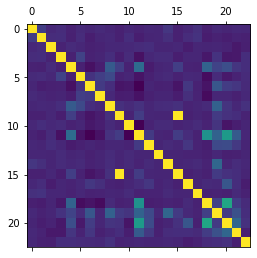

In [96]:
import matplotlib.pyplot as plt

df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v
df = df[food_cmp_level5]
corr = df.corr()
#plot(corr.style.background_gradient(cmap='coolwarm'))
plt.matshow(corr)
plt.show()

The correlation matrix does not show any high correlations among the components. The correlation values are actually quite low. Just as an extra cautionary step, the section below attempts to use a PCA transformation of the observation space and use the principal components to re-fit the model.

In [15]:
import numpy as np
from sklearn.decomposition import PCA

df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')

X = df[food_cmp_level5]
pca = PCA(n_components=5)
pca_x = pca.fit(X)
df_pca = pca_x.transform(X)
df_new = pd.DataFrame(df_pca)


df_new['seafood_meal'] = df['seafood_meal']

var_sel = [0,1,2,3,4]


print(pca_x.explained_variance_ratio_)




test_pred_sr_tot=[]
train_pred_sr_tot=[]
for i in range(100):
    test_pred_sr, train_pred_sr = nhanes_full_log_reg(df = df_new,
                                   fped_vars = var_sel, 
                                   non_sfd_class_n = 1000, 
                                   sfd_class_n = 1000, 
                                   test_ratio = 0.2)
    test_pred_sr_tot.append(test_pred_sr)
    train_pred_sr_tot.append(train_pred_sr)


test_pred_sr_tot = pd.DataFrame(test_pred_sr_tot)
test_pred_sr_tot = test_pred_sr_tot.astype(float)
train_pred_sr_tot = pd.DataFrame(train_pred_sr_tot)
train_pred_sr_tot = train_pred_sr_tot.astype(float)
print(test_pred_sr_tot.describe())
print(train_pred_sr_tot.describe())

df_new.describe()

[0.57740584 0.32557929 0.0784561  0.01022015 0.00256172]
                0
count  100.000000
mean     0.652525
std      0.024370
min      0.580000
25%      0.637500
50%      0.647500
75%      0.668125
max      0.715000
                0
count  100.000000
mean     0.654188
std      0.010398
min      0.625000
25%      0.647344
50%      0.653438
75%      0.662500
max      0.675625


,0,1,2,3,4,seafood_meal
count,2.924300e+04,2.924300e+04,2.924300e+04,2.924300e+04,2.924300e+04,29243.000000
mean,1.798703e-15,6.536280e-15,-4.624569e-17,1.979138e-16,7.060715e-17,0.110522
std,1.496078e+01,1.123420e+01,5.514767e+00,1.990409e+00,9.965044e-01,0.313545
min,-1.424377e+01,-3.693371e+01,-2.491005e+01,-1.378501e+01,-1.841469e+00,0.000000
25%,-1.039567e+01,-6.831654e+00,-2.858451e+00,-1.133901e+00,-3.043622e-01,0.000000
50%,-4.324786e+00,-3.456396e+00,-1.725188e+00,-2.619344e-01,-2.329680e-01,0.000000
75%,5.569037e+00,3.391805e+00,1.736275e+00,8.096234e-01,-1.748552e-01,0.000000
max,1.774602e+02,2.593593e+02,1.076395e+02,1.830589e+01,1.659055e+01,1.000000


The model above is fitted 100 different times, to account for the variances in the sampling of the data. The results above are showing the success rate distribution of these 100 runs. Five principal components, which explain most of the variation within the data, were used to re-fit the model. This model is actually performing worse than the original, re-iterating that correlation within the components is not an issue for this dataset.

**Section 2: Component-Wise Linear Regression**

This section explores a linear regression model, targetting each one of the components while using the others. In this manner we can see how changing the amount of seafood on a plate will affect each of the components. 

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

def linear_regressor(df, obs_space, target, n_sfd, n_non_sfd):
    df_non_sfd = df[df['seafood_meal']==0].sample(n=n_non_sfd)
    df_sfd = df[df['seafood_meal']==1].sample(n=n_sfd)
    df = pd.concat([df_non_sfd, df_sfd])
    df_x = df[obs_space]
    df_y = df[target]
    lin_reg = LinearRegression()
    lin_reg.fit(df_x, df_y)
    y_pred = lin_reg.predict(df_x)
    lin_mse = mean_squared_error(df_y, y_pred)
    lin_mse = np.sqrt(lin_mse)
    lin_r2 = r2_score(df_y, y_pred)
    return target, lin_r2, lin_mse, df[target].describe()['mean'], df[target].describe()['std']


food_cmp_level6 = ['F_CITMLB', 'F_OTHER', 'F_JUICE', 
                   'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT', 'PF_MEAT', 'PF_SEAFD_TOT',
                   'D_MILK', 'D_YOGURT', 'D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']  

#Read the pre-processed dataframe.
df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')

result = []
for var in food_cmp_level6:
    obs_space = list(food_cmp_level6)
    obs_space.remove(var)
    #print(variables)
    target = var
    result_temp = linear_regressor(df, obs_space, var, 500, 500)
    result.append(result_temp)
    
result = pd.DataFrame(result)
result = result.rename(columns={0: "Regression Target", 1: "R^2", 2: "RMSE", 3: "Target Mean", 4:"Target SD"})
result = result.sort_values(by="R^2", ascending = False)
print(result)

   Regression Target       R^2       RMSE  Target Mean  Target SD
24        SOLID_FATS  0.488401  10.013990     10.55589  14.007465
22          D_CHEESE  0.468449   0.437460      0.21444   0.600320
23              OILS  0.325445   9.751514      9.85552  11.879022
10         G_REFINED  0.323397   1.823277      2.09176   2.217700
19      PF_SEAFD_TOT  0.288836   2.525525      1.83201   2.996290
18           PF_MEAT  0.208648   1.481895      0.70173   1.666671
6   V_STARCHY_POTATO  0.192106   0.321119      0.14430   0.357443
4     V_REDOR_TOMATO  0.171867   0.256515      0.14051   0.282021
13         PF_NUTSDS  0.154644   0.391540      0.05461   0.426062
17          PF_POULT  0.153676   1.587469      0.68087   1.726451
25        ADD_SUGARS  0.153480   5.298738      3.61063   5.761971
8            V_OTHER  0.141773   0.462492      0.33273   0.499483
15      PF_CUREDMEAT  0.139455   0.816721      0.28877   0.880855
11           PF_EGGS  0.116634   0.288373      0.10681   0.306974
9         

The table above is showing the results of the linear regression model, targeting each component. The performance metric is the the standard model Root Mean Square Error, or RMSE. Given that each component has different units and distribution characteristics, the regression target component statistics are disaplyed above. The table is sorted by the R-squared result of the model. This provides an indication of how well the model predicts the quantities of the target component. As we can see, the better performing models are when regressing on SOLID_FATS and D_CHEESE. However, even for these models, the R-squared result is not very high.

**Model Interpretation**

The linear regression model is represented by the following equation:

$$\hat{y} = \beta_0 + \beta_1X_1 + ... + \beta_pX_p$$

The interpretation here is that changing the value of a component by some unit, while holding all the other parameters constant, will change the prediction value by:

$$\delta\hat{y} = \beta_n \delta X_n$$

Since the linear regression on solid fats performed the best, we can use this as an example. 

In [124]:
def linear_regressor_params(df, obs_space, target, n_sfd, n_non_sfd):
    df_non_sfd = df[df['seafood_meal']==0].sample(n=n_non_sfd)
    df_sfd = df[df['seafood_meal']==1].sample(n=n_sfd)
    df = pd.concat([df_non_sfd, df_sfd])
    df_x = df[obs_space]
    df_y = df[target]
    lin_reg = LinearRegression()
    lin_reg.fit(df_x, df_y)
    y_pred = lin_reg.predict(df_x)
    lin_mse = mean_squared_error(df_y, y_pred)
    lin_mse = np.sqrt(lin_mse)
    return lin_reg.coef_, lin_reg.intercept_


obs_space = list(food_cmp_level6)
obs_space.remove('SOLID_FATS')
lin_reg_coefficients, lin_reg_intercept = linear_regressor_params(df, obs_space, 'V_LEGUMES', 500, 500)

print("The linear regression predictor variables are: \n", obs_space)
print("\n")
print("The linear regression coefficients on SOLID_FATS are: \n", lin_reg_coefficients)
print("\n")
print("The linear regression intercept on SOLID_FATS is: \n", lin_reg_intercept)
print("\n")
print("The linear regression coefficient for PF_SEAFD_TOT is: \n", lin_reg_coefficients[19])
print("\n")
print("So increasing the PF_SEAFD_TOT value by 1 unit, will change the amount of solid fats by: ", lin_reg_coefficients[19])
print("\n")
print("And decreasing the PF_SEAFD_TOT value by 1 unit, will change the amount of solid fats by ", -lin_reg_coefficients[19])

The linear regression predictor variables are: 
 ['F_CITMLB', 'F_OTHER', 'F_JUICE', 'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 'V_STARCHY_OTHER', 'V_OTHER', 'G_WHOLE', 'G_REFINED', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT', 'PF_MEAT', 'PF_SEAFD_TOT', 'D_MILK', 'D_YOGURT', 'D_CHEESE', 'OILS', 'ADD_SUGARS', 'A_DRINKS']


The linear regression coefficients on SOLID_FATS are: 
 [ 9.36136806e-05 -3.07388895e-04  5.23706205e-04  5.68146634e-05
  1.42595451e-04 -5.59135261e-04  6.08344288e-05 -2.41502561e-04
 -2.14181140e-04  1.63839757e-05  9.71694764e-05 -6.33311412e-04
  3.22683943e-04  1.83353777e-04  2.48870266e-01 -5.36502668e-05
 -1.32913699e-05  5.42045282e-05  9.21734886e-06 -2.70821736e-06
  2.38046579e-04  1.12222444e-03 -1.67284936e-04  1.71555880e-06
 -1.61058470e-05  1.46566527e-04]


The linear regression intercept on SOLID_FATS is: 
 -9.028702816244599e-05


The linear regression coefficient for PF_SEAFD_TOT i

So even in this model, the coefficient for PF_SEAFD_TOT is too small to be used reliably for making inferences on how solid fats are consumed among seafood and non seafood meals. In addition to this, the poor performance on the linear regression when targeting the other components, indicates that a linear regression does not best represent the behavior in the real world. This model is most likely experiencing similar issues as the logistic regression model, where the distribution characterisitcs of the input data are not suited for regression. 

**Section 3: Decision Tree Model**

Decision trees are an alternative to the regression approach, while still providing a certain level of explainability of the data features. Given the statistical characteristics of the features in this dataset, a decision tree may provide a more suitable model of the real world behavior. 

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

def tree_regressor(df, components, n_sfd, n_non_sfd):
    df_non_sfd = df[df['seafood_meal']==0].sample(n=n_non_sfd)
    df_sfd = df[df['seafood_meal']==1].sample(n=n_sfd)
    df = pd.concat([df_non_sfd, df_sfd])
    df_x = df[components]
    df_y = df['seafood_meal']
    X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred_tree = decision_tree.predict(X_test)
    y_pred_tree_train = decision_tree.predict(X_train)
    #score = decision_tree.score(X_test, y_test)
    score = accuracy_score(y_test, y_pred_tree)
    score_train = accuracy_score(y_train, y_pred_tree_train)
    tree_rules = export_text(decision_tree, feature_names=list(X_train.columns))
    return score, score_train, tree_rules


df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')

food_cmp_level5 = ['F_CITMLB', 'F_OTHER', 'F_JUICE', 
                   'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'D_MILK', 'D_YOGURT', 'D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']  

var_sel = [0,1,2,3,4]

result = []
result_train = []
for i in range(100):
    model_fit, train_results, tree_rules = tree_regressor(df_new, var_sel, 1000, 1000)
    result.append(model_fit)
    result_train.append(train_results)

result = pd.DataFrame(result)
print(result.describe())

result_train = pd.DataFrame(result_train)
print(result_train.describe())

                0
count  100.000000
mean     0.588875
std      0.025777
min      0.520000
25%      0.570000
50%      0.587500
75%      0.607500
max      0.647500
                0
count  100.000000
mean     0.998569
std      0.000946
min      0.996250
25%      0.998125
50%      0.998750
75%      0.999375
max      1.000000


The prediction success rate is not much higher for this model. 

**Model Interpretation**

The resulting decision tree is depicted below. The tree contains a high amount of branches, due to the high amount of components.

In [5]:
print(tree_rules)

|--- 0 <= -7.10
|   |--- 1 <= -3.08
|   |   |--- 0 <= -12.49
|   |   |   |--- 3 <= 2.82
|   |   |   |   |--- 4 <= -0.24
|   |   |   |   |   |--- 1 <= -6.56
|   |   |   |   |   |   |--- 2 <= -1.07
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- 2 >  -1.07
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- 1 >  -6.56
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- 4 >  -0.24
|   |   |   |   |   |--- 0 <= -12.91
|   |   |   |   |   |   |--- 0 <= -13.86
|   |   |   |   |   |   |   |--- 3 <= -0.88
|   |   |   |   |   |   |   |   |--- 4 <= -0.14
|   |   |   |   |   |   |   |   |   |--- 1 <= -6.86
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- 1 >  -6.86
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- 4 >  -0.14
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- 3 >  -0.88
|   |   |   |   |   |   |   |   |--- 2 <= -1.63
| 

**Support Vector Machine Model**

A Support Vector Machine model does not provide any explainability of the model features, but is explored here to see if it can provide any improvement in performance. 

In [14]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')
df = df[df['meal_energy']=='Medium-Low']


def svm_regressor(df, variables, n_sfd, n_non_sfd, param):

    df_non_sfd = df[df['seafood_meal']==0].sample(n=n_non_sfd)
    df_sfd = df[df['seafood_meal']==1].sample(n=n_sfd)
    df = pd.concat([df_non_sfd, df_sfd])

    X = df[variables]
    Y = df['seafood_meal']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    #svm_nhanes = LinearSVC(C=1, loss="hinge")
    
    svm_nhanes = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=param, loss="hinge"))
    ])

    #svm_nhanes = LinearSVC(C=1, loss="hinge")
    svm_nhanes.fit(X_train, y_train)
    y_pred_svm = svm_nhanes.predict(X_test)
    score = accuracy_score(y_test, y_pred_svm)
    y_pred_svm_train = svm_nhanes.predict(X_train)
    score_train = accuracy_score(y_train, y_pred_svm_train)
    return score, score_train

var_sel = [0,1,2,3,4]  

result = []
result_train = []
for i in range(100):
    model_fit, train_result = svm_regressor(df_new, var_sel, 500, 500, 1)
    result.append(model_fit)
    result_train.append(train_result)

result = pd.DataFrame(result)
result_train = pd.DataFrame(result_train)
print(result.describe())
print(result_train.describe())


                0
count  100.000000
mean     0.626700
std      0.037025
min      0.510000
25%      0.600000
50%      0.625000
75%      0.655000
max      0.715000
                0
count  100.000000
mean     0.635637
std      0.018919
min      0.583750
25%      0.621250
50%      0.635625
75%      0.651250
max      0.673750


This model does not provide any improvement in performance from the previous models.

